CNN para classificação de falhas

Disciplina: Redes Neurais Artificiais

Professor: Thomas Rauber

Grupo:
- Alan Carlos Pereira Pinto
- Alexander de Oliveira da Silva
- Iran Freitas Ribeiro

--------------------------------------------------------


**Sumarização do modelo**

Construímos um classificador CNN para, dado um conjunto de entrada, retornar de qual das 21 classes de falha ele pertence. A estrutura geral do modelo está descrita à seguir:

``CNN -> MaxPooling2D -> Dropout -> CNN -> MaxPooling2D -> Dropout -> Dense -> Dropout -> Dense``

Para esse problema, a camada Dense retorna um vetor com 21 valores de "probabilidade", de forma que a posição com a maior "probabilidade" representa o número da classe que o modelo classifica os conjunto de entrada.

## Treinamento

O modelo é treinado por, no máximo, 200 épocas, com um batch size de 256. Para reduzir o *overfitting*, fazemos com que a taxa de aprendizado sofra um decaimento ao longo do treinamento. Além disso, utilizamos um callback que para o treinamento quando o *loss* nos dados de validação não tem uma melhora após 10 épocas seguidas ([Eearly Stopping](https://keras.io/api/callbacks/early_stopping/)).

A acurácia do modelo, em cada época de treinamento, é mostrada no final do notebook.

In [4]:
import pandas as pd
import numpy as np
import glob
import tensorflow as tf
from tensorflow.keras import models, layers, losses, regularizers, callbacks, constraints, optimizers
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [5]:
def normalize(d):
    media_treino = d.mean(axis=0)
    std_treino = d.std(axis=0, ddof=0)
    d = d - media_treino
    d = d/std_treino
    return d
    
def unir_df_treino(cols):
    df = pd.DataFrame()
    for i in range(22):
        fnm = ''+str(i).zfill(2)
        dfalha_i = pd.read_csv('data/d{}.dat'.format(fnm), delim_whitespace=True, header=None)
        dfalha_i['falha'] = np.ones(len(dfalha_i), dtype='int')*i # 1
        df = pd.concat([df, dfalha_i])
    X = df[cols].values
    labels_treino = df['falha'].values
    X = normalize(X)
    X = X.reshape(len(X), 13, 2, 2)
    labels_treino = labels_treino.reshape(len(labels_treino), 1)
    return X, labels_treino

def get_df_teste(cols):
    df = pd.DataFrame()
    for i in range(22):
        fnm = ''+str(i).zfill(2)
        dfalha = pd.read_csv('data/d{}_te.dat'.format(fnm), delim_whitespace=True, header=None)
        dfalha['falha'] = np.ones(len(dfalha), dtype='int')*i
        # primeiros 160 são dados de normalidade
        dfalha.loc[np.arange(160), 'falha'] = 0
        df = pd.concat([df, dfalha])
    X = df[cols].values
    labels = df['falha'].values
    X = normalize(X)
    X = X.reshape(len(X), 13, 2, 2)
    labels = labels.reshape(len(labels), 1)
    return X, labels

In [11]:
def define_model(dropouts=[], lnormalize=False, r=1, thirdl=False, n_steps=10, nouts=2):
    """
    Retorna um modelo CNN

    Params:
        - dropout: lista de camadas onde o dropout será aplicado
        - lnormalize: indica se normalização l2 será aplicado à camada
        - r: número utilizado para reduzir o número de neurônios em cada camada
        - thirdl: indica se o modelo possui uma camada CNN adicional no final. O modelo mais simples possui apenas 2 camadas
        - n_steps: controla TODO: REMOVER
    """

    m  = models.Sequential()
    if lnormalize:
        m.add(layers.Conv2D(int(64/r), (2, 2), activation='relu', input_shape=(13, 2, 2), name='conv1', kernel_regularizer=regularizers.l2(0.01)))
    else:
        m.add(layers.Conv2D(int(64/r), (2, 2), activation='relu', input_shape=(13, 2, 2), name='conv1'))
    m.add(layers.MaxPooling2D((2, 1), name='maxpooling1'))
    if dropouts[0]:
        m.add(layers.Dropout(0.4))
    if lnormalize:
        m.add(layers.Conv2D(int(64/r), (2, 1), activation='relu', name='conv2', 
            kernel_regularizer=regularizers.l2(0.01)))
    else:
        m.add(layers.Conv2D(int(64/r), (2, 1), activation='relu', name='conv2'))    
    if thirdl:        
        m.add(layers.MaxPooling2D((2, 1), name='maxpooling2'))
        if dropouts[1]:
            m.add(layers.Dropout(0.4))
        if lnormalize:
            m.add(layers.Conv2D(int(64/r), (2, 1), activation='relu', name='conv3', 
                kernel_regularizer=regularizers.l2(0.01)))
        else:
            m.add(layers.Conv2D(int(64/r), (2, 1), activation='relu', name='conv3'))
    m.add(layers.Flatten())
    m.add(layers.Dense(int(32/r), activation='relu'))
    if thirdl:
        if dropouts[2]:
            m.add(layers.Dropout(0.2))
    # 2 classes: normal (0) e falha (XX)
    m.add(layers.Dense(nouts, name="previsoes"))
    opt = optimizers.Adam(learning_rate=1e-4)
    #opt = optimizers.SGD()
    m.compile(optimizer=opt, loss=losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    return m

def plot_acc_loss(title, hist):
    """
    Plota a accurácia (treino e validação) e perda (treino e validação) do modelo ao longo das épocas    
    """
    fig, ax = plt.subplots(ncols=2, figsize=(8,3))
    ax[0].plot (hist.history['accuracy'], label='acc')
    ax[0].plot (hist.history['val_accuracy'], label='val_acc')
    ax[0].legend()
    ax[1].plot (hist.history['loss'], label='loss')
    ax[1].plot (hist.history['val_loss'], label='val_loss')
    ax[1].legend()
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    
    return callbacks.LearningRateScheduler(schedule)

In [6]:
# seleciona os dados de treino
colunas = np.arange(52)
X_treino, labels_treino = unir_df_treino(colunas)
X_teste, labels_teste = get_df_teste(colunas)

In [9]:
cnn_falhas = define_model(dropouts=[1,1,1],r=0.1, lnormalize=False, thirdl=1, nouts=22)

In [12]:
bs = 256
n_steps = X_treino.shape[0]//bs
lr_sched = step_decay_schedule(initial_lr=1e-4, decay_factor=0.75, step_size=n_steps)

In [13]:
es = callbacks.EarlyStopping(monitor='val_loss', patience=10)
hist = cnn_falhas.fit(X_treino, labels_treino, verbose=1, batch_size=bs, epochs=200,
                     validation_data=(X_teste, labels_teste), callbacks=[es, lr_sched])

Epoch 1/200
42/42 [==============================] - 8s 182ms/step - loss: 2.9447 - accuracy: 0.0965 - val_loss: 2.8120 - val_accuracy: 0.1760 - lr: 1.0000e-04
Epoch 2/200
42/42 [==============================] - 7s 178ms/step - loss: 2.6572 - accuracy: 0.2314 - val_loss: 2.5768 - val_accuracy: 0.2188 - lr: 1.0000e-04
Epoch 3/200
42/42 [==============================] - 7s 178ms/step - loss: 2.3929 - accuracy: 0.2760 - val_loss: 2.3917 - val_accuracy: 0.2517 - lr: 1.0000e-04
Epoch 4/200
42/42 [==============================] - 8s 185ms/step - loss: 2.1952 - accuracy: 0.3253 - val_loss: 2.2302 - val_accuracy: 0.2903 - lr: 1.0000e-04
Epoch 5/200
42/42 [==============================] - 8s 189ms/step - loss: 2.0776 - accuracy: 0.3579 - val_loss: 2.1618 - val_accuracy: 0.3050 - lr: 1.0000e-04
Epoch 6/200
42/42 [==============================] - 7s 179ms/step - loss: 1.9896 - accuracy: 0.3756 - val_loss: 2.1052 - val_accuracy: 0.3186 - lr: 1.0000e-04
Epoch 7/200
42/42 [=====================

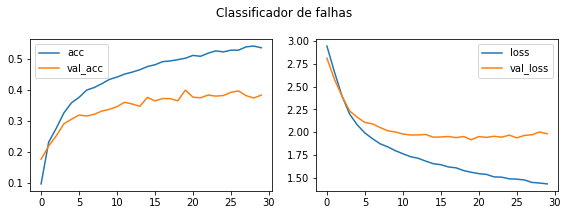

In [14]:
plot_acc_loss("Classificador de falhas", hist)

In [15]:
cnn_falhas.save("modelos/classificador_falhas.h5")